# Iterative Prisoner's Dilemma


### Description

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function. Possible strategies are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

Many more and much more complex strategies can be implemented. The strategy can even change during the IPD.


### Assignments

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* (*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


## Basic elements and 1-on-1 matches

In [1]:
import numpy as np
from numpy.random import random as npr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import seaborn as sn

We start by defining a `Player` class. Many options will be clear later.

In [2]:
class Player:
    def __init__(self, k, t):
        self.k = k
        self.t = t
    
    def play(self, hist):
        t = npr()
        if t < self.t: 
            if len(hist) > 0:
                return hist[-1]
            else:
                return True
        elif t < -self.t:
            if len(hist) > 0:
                return not hist[-1]
            else:
                return False
        
        return npr() < self.k

    def name(self):
        # name string for legends in plots, etc.
        return rf"$k = {self.k:.2f}$, $t = {self.t:.2f}$"
    
    def check(self):
        if self.t > 1:
            self.t = 1
        if self.t < -1:
            self.t = -1
        if self.k > 1:
            self.k = 1
        if self.k < 0:
            self.k = 0
    
    def init_values(self):
        return self.k, self.t
    
    def randomize(self):
        self.k += (2 * npr() - 1) * 0.05
        self.t += (2 * npr() - 1) * 0.05
        self.check()
        return self

Then a function that implements the basic 1-on-1 game mechanics. The default payoff matrix will be
$$
    M = \begin{pmatrix} 2 & 0 \\ 3 & 1 \end{pmatrix},
$$
corresponding to
$$
    R = 2,\, S = 0,\, T = 3,\, P = 1.
$$
If both players cooperate, they both receive 2 points (**R**eward). If they betray each other, they each receive 1 point (**P**unishment). If one player betrays their cooperative opponent, the betrayer receives 3 points (**T**emptation payoff) while the betrayed player gets 0 (**S**ucker’s payoff).

In [3]:
def game(pl1, pl2, it, payoff=(3, 2, 1, 0)):
    hist1 = [] # only for the correct init of tit-for-tat
    hist2 = [] # same
    points = [0, 0]
    
    for i in range(it):
        res1 = pl1.play(hist2)
        res2 = pl2.play(hist1)
        hist1.append(res1)
        hist2.append(res2)
        if res1 and res2:
            points[0] += payoff[1]
            points[1] += payoff[1]
        elif res1 and not res2:
            points[1] += payoff[0]
            points[0] += payoff[3]
        elif not res1 and res2:
            points[1] += payoff[3]
            points[0] += payoff[0]
        else:
            points[0] += payoff[2]
            points[1] += payoff[2]
 
    return points

Then, we define the following basic strategies:
* _nice player_, a player who always cooperates;
* _evil player_, a player who always betrays.

And the intermediate versions:
* _average player_, a player who cooperates half the time;
* _mostly nice player_, a player with a cooperation probability of 0.75;
* _mostly bad player_, a player with a cooperation probability of 0.25.

Also, we’ll implement a basic example of a different kind of strategy, commonly referred to as “tit-for-tat”. A tit-for-tat player starts by cooperating on the first iteration and then copies their opponent’s previous move from that point forward.

In [4]:
nice_pl = Player(1, 0)
evil_pl = Player(0, 0)
avg_pl = Player(0.5, 0)
mnice_pl = Player(0.75, 0)
mevil_pl = Player(0.25, 0)
tt_pl = Player(0, 1)

Let’s examine some 1-on-1 matchups of these strategies.

The result of a nice versus evil match is easily predicted: Nice will always receive the sucker’s payoff, while Evil will receive a temptation reward in every iteration, resulting in a score of T times the number of iterations to zero in favour of the betrayer.

If the number of iterations is large enough, matchups between mostly nice/evil players are also predictable. For example, in the Evil versus Average matchup, the score ratio will converge to 4 in favour of Evil.
This is because half the time both players will receive $P = 1$ points (reciprocal betrayal), while in the other instances Evil will receive $T=3$ points and Average will receive $S = 0$. So, if $E$ is Evil’s score and $A$ is Average’s,
$$
    \frac{E}{A} \approx \frac{P / 2 + T / 2}{P / 2 + S / 2} = 4.
$$
Indeed:

In [5]:
iters = 1000
evil_v_avg = game(evil_pl, avg_pl, iters)
print(f"Evil v Average:\n {evil_v_avg}")
print(f"Score ratio: {evil_v_avg[0]} / {evil_v_avg[1]} \
= {evil_v_avg[0] / evil_v_avg[1]}")

Evil v Average:
 [1994, 503]
Score ratio: 1994 / 503 = 3.9642147117296225


Betrayal usually prevails, as seen in the classic dilemma. The situation becomes more interesting when a Tit-for-tat player is introduced. Let’s observe how they fare with the reigning champion.

In [6]:
tt_v_evil = game(tt_pl, evil_pl, iters)
print(f"Tit-for-tat v Evil:\n {tt_v_evil}")

Tit-for-tat v Evil:
 [999, 1002]


Evil wins by three points. The first move is crucial: Tit-for-tat cooperates initially and hence loses three points to Evil. From that point on, they engage in reciprocal betrayal in every turn, resulting in each player earning one point. With our 1000 iterations, the final score becomes 999 to 1002.

Then, what happens to the other players? To get the full picture, we’ll play a small tournament among these six players and look at the averaged scores at the end.

<AxesSubplot: >

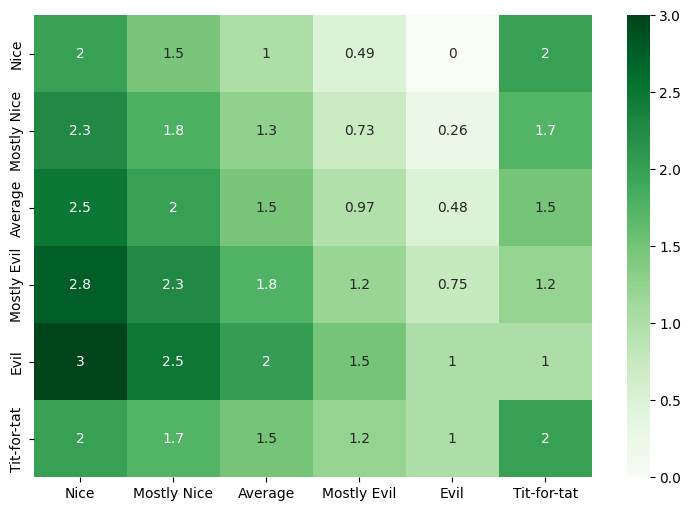

In [7]:
def tournament(players, iters):
    N = len(players)
    results = np.zeros((N, N))
    for i in range(N):
        # start from i to allow players to compete against themselves
        for j in range(i, N):
            score = game(players[i], players[j], iters)
            # results[i, j] is the sum of all points made
            # by player i when playing j
            results[i, j] += score[0]
            if i == j:
                continue # avoid double counting
            results[j, i] += score[1]

    # return average points per iteration
    return results / (iters)

players=[nice_pl, mnice_pl, avg_pl, mevil_pl, evil_pl, tt_pl]
player_names = ["Nice", "Mostly Nice", "Average", "Mostly Evil", "Evil", "Tit-for-tat"]

results = tournament(players, 1000)
results = pd.DataFrame(results,
                       index=player_names,
                       columns=player_names)

plt.figure(figsize=(9, 6))
sn.heatmap(results, annot=True, cmap="Greens")

The entries in the tournament matrix indicate the average score achieved by the player associated with the corresponding row, across all rounds, against the player represented by the column.

Thus, by taking the average along the rows, we can determine which
player performs the best, on average.

In [8]:
standings = results.mean(axis=1).sort_values(ascending=False)
standings

Evil           1.834667
Mostly Evil    1.661667
Tit-for-tat    1.579667
Average        1.486333
Mostly Nice    1.344167
Nice           1.158667
dtype: float64

The evil players win, once again!

However, if we look the average score obtained by each player *against themselves*, we get this:

In [9]:
standings_self = pd.Series(np.diag(results),
                           index=player_names).sort_values(ascending=False)
standings_self

Nice           2.000
Tit-for-tat    2.000
Mostly Nice    1.787
Average        1.463
Mostly Evil    1.185
Evil           1.000
dtype: float64

So, Evil players do well against other types of players, but their
individualistic strategy leads to suboptimal outcomes for the population
as a whole. A completely Evil population will result in the least favourable
distribution of rewards.

On the other end of the spectrum are Nice and Tit-for-tat players.
Out of these two, as we’ve seen above, Tit-for-tat has a better performance
across the board. If we were to look at it from a “Survival of the Fittest”
perspective, we’d expect Tit-for-tat – or some variant of it – to
become the dominant strategy. This is what we’ll investigate in the next
section.

Before that, let’s try to implement some additional strategies to see if there are other type of players with similar or better performance.

In [10]:
from numpy import sum as np_sum
from numpy import random

class SusTFT:
    def __init__(self, *args):
        pass
    
    def init_values(self):
        return (None,)
    
    def play(self, hist):
        if len(hist) > 0:
            return hist[-1]
        else:
            return False
    
    def name(self):
        return "Suspicious Tft"

class Spiteful:
    def __init__(self, *args):
        pass
    
    def init_values(self):
        return (None,)
    
    def play(self, hist):
        if False in hist:
            return False
        else:
            return True
    
    def name(self):
        return "Spiteful"

class Periodic:
    def __init__(self, *args):
        self.seq = args
        self.cnt = -1
    
    def init_values(self):
        return self.seq
    
    def play(self, hist):
        self.cnt += 1
        if self.cnt >= len(self.seq):
            self.cnt = 0
        return self.seq[self.cnt]
    
    def name(self):
        return "Periodic "+str([int(i) for i in self.seq])

class TF2T:
    def __init__(self, *args):
        pass
    
    def init_values(self):
        return (None,)
    
    def play(self, hist):
        if len(hist) > 1:
            return hist[-1] or hist[-2]
        else:
            return True
        
    def name(self):
        return "Tit-for-2-tats"

class Majority:
    def __init__(self, typ): ## True -> soft  ##  False -> hard
        self.typ=typ
    
    def init_values(self):
        return (self.typ,)
    
    def play(self, hist):
        if len(hist) > 0:
            if self.typ:
                return np_sum(hist) >= (len(hist) // 2)
            else:
                return not np_sum(hist) <= (len(hist) // 2)
        else:
            if self.typ:
                return True
            else:
                return False
    
    def name(self):
        return "Majority "+str(self.typ)

class HTFT:
    def __init__(self, *args):
        pass
    
    def init_values(self):
        return (None,)
    
    def play(self, hist):
        res = True
        if len(hist) > 0:
            res = res and hist[-1]
        if len(hist) > 1:
            res = res and hist[-2]
        if len(hist) > 2:
            res = res and hist[-3]
        return res
    
    def name(self):
        return "Hard TFT"
    

class Responsive:
    def __init__(self,k, a):
        self.k = k
        self.a = a
    
    def init_values(self):
        return self.k, self.a
    
    def play(self, hist):
        if len(hist)==0:
            return random.random()<self.k
        return random.random() < self.k + self.a * ((np_sum(hist) / len(hist)) - 0.5)
    
    def name(self):
        return "Responsive ("+str(self.k)+", "+str(self.a)+")"

    
def init_classed(N):
    pl=[]
    for i in range(N//17):
        pl.append(Player(0,0))
        pl.append(Player(0.25,0))
        pl.append(Player(0.5,0))
        pl.append(Player(0.75,0))
        pl.append(Player(1,0))
        
        pl.append(Player(0.5,1))
        pl.append(Player(0.5,-1))
        
        pl.append(SusTFT())
        pl.append(Spiteful())
        pl.append(Periodic(True, False))
        pl.append(Periodic(True, True, False))
        pl.append(Periodic(True, False, False))
        pl.append(TF2T())
        pl.append(Majority(True))
        pl.append(Majority(False))
        pl.append(HTFT())
    
        pl.append(Responsive(0.5,0.5))
    while len(pl)<N:  
        pl.append(Player(0.5,0))
    
    return pl

Like before, we’ll simulate a round-robin tournament and display the average score for each player across all matchups, and the score that they obtained against other instances of themselves.

In [11]:
players = init_classed(17)
player_names = [pl.name() for pl in players]

results = tournament(players, 1000)
results = pd.DataFrame(results,
                       index=player_names,
                       columns=player_names)
data = pd.DataFrame({"Score vs self":np.diag(results),
                     "Average score":results.mean(axis=1)}, index=player_names)
data = data.sort_values(["Average score", "Score vs self"], ascending=False)
data

,Score vs self,Average score
Spiteful,2.000,1.849941
Hard TFT,2.000,1.764000
"$k = 0.50$, $t = 1.00$",2.000,1.648529
Majority True,2.000,1.641882
"$k = 0.00$, $t = 0.00$",1.000,1.616588
Tit-for-2-tats,2.000,1.581471
Majority False,1.000,1.468353
"$k = 0.25$, $t = 0.00$",1.222,1.459529
"Responsive (0.5, 0.5)",1.525,1.448412
Suspicious Tft,1.000,1.440647


Once again, the Tit-for-tats players come out on top on the self-score metric, while retaining an above-average score across all metrics. When considering both columns, the best-performing player actually is the “Spiteful” player. Like we’ve seen, Spiteful begins by cooperating and continues to do so until the opponent defects, after which it always defects. This strategy works well against Tit-for-tat and Nice players because they both continue to cooperate throughout the game, while against Evil players it correctly avoids cooperating and being taken advantage of.

In the next section we’ll repeat the tournament in a “Survival of the fittest” scenario, to effectively showcase the main strength of Tit-for-tats and similar players, which is their ability to perform well with each other and well enough with nearly every other strategy.

## Battle Royale

In this section we’ll implement an “evolutionary” round-robin tournament: we’ll keep a fixed total population of players throughout the tournament, but the number of players in each class will change proportionally to the scores in the previous round. We’ll start with a uniform distribution of the six strategies we discussed in the previous section.

In [12]:
def init_classed(num_players):
    return np.array([Player(1, 0), Player(0.75, 0), Player(0.5, 0), 
                     Player(0.25, 0), Player(0, 0), Player(0, 1)]
                    * (num_players // 6)
                    # fill remaining spots with Average players
                    + [Player(0.5, 0)] * (num_players % 6))

The next function, `repeated`, performs a run of a given number of cycles 
and stops it if the scores remain unchanged for 20 consecutive cycles, with
a tolerance of 0.001%. The function `select` is used to sort the results
and adjust the distribution of the population according to the following 
rule:
$$
    C_i^{(n + 1)} = C_i^{(n)} \biggl(1 + \frac{S_i^{(n)} - \mu_{\vphantom{i}}^{(n)}}{\mu^{(n)}}\biggr),
$$
where $C_i^{(n)}$ is the number of players in the class (strategy) $i$ at the $n$-th
cycle, $S_i^{(n)}$ the score of the $i$-th class, and
$$
    \mu^{(n)} = \frac{1}{N_\mathrm{p}} \sum_{i = 1}^{N_\mathrm{c}}
    C_i^{(n)} S_i^{(n)}
$$
with $N_\mathrm{c}$ the number of classes and $N_\mathrm{p}$ the total number of players. Here is a simple proof that the total population doesn’t change using this update rule:
$$
    \sum_{i=1}^{N_\mathrm{c}} C_{i}^{(n + 1)} = \sum_{i = 1}^{N_\mathrm{c}} {}\Biggl[C_i^{(n)} + 
    \frac{C_i^{(n)}}{\mu^{(n)}} \Biggl(S_i^{(n)} - \frac{1}{N_\mathrm{p}} \sum_{j = 1}^{N_\mathrm{c}} C_j^{(n)} S_j^{(n)} \Biggr)\Biggr],
$$
and since $C_i^{(n)} = N_\mathrm{p}$,
$$
    \sum_{i = 1}^{N_\mathrm{c}} C_{i}^{(n + 1)} 
    = N_\mathrm{p} + 
        \frac{1}{\mu^{(n)}} \sum_{i=1}^{N_\mathrm{c}} C_i^{(n)} S_i^{(n)} 
        - \frac{N_\mathrm{p}}{\mu^{(n)}} \sum_{j = 1}^{N_\mathrm{c}} \frac{C_{j}^{(n)} S_j^{(n)}}{N_\mathrm{p}} = N_\mathrm{p}.
$$
So, the strategies with higher scores will reproduce more, while the population with below-average performance will decrease as the tournament progresses.

We’ll also redefine the tournament function to perform the calculations in parallel, to better handle a large number of players.

In [13]:
from multiprocessing import Pool 

def round_robin(players, iters):
    N = len(players)

    results = [[None for i in range(N)] for j in range(N)]
    scores = [0 for i in range(N)]

    with Pool() as p:
        for i in range(N):
            for j in range(i + 1, N):
                res = p.apply_async(game, (players[i], players[j], iters))
                results[i][j] = res
        
        for i in range(N):
            for j in range(i + 1, N):
                res = results[i][j].get()
                scores[i] += res[0]
                scores[j] += res[1]
    
    return scores

In [14]:
def select(players, scores, notquite=False):
    num_players = len(players)
    
    types = []
    for p in players:
        player_type = (p.__class__, p.init_values())
        for t in types:
            if t == player_type:
                break
        else:
            types.append(player_type)

    sc_by_type = []
    num_by_type = []

    for idx_t, t in enumerate(types):
        t_score = []
        for idx_p, p in enumerate(players):
            if t == (p.__class__, p.init_values()):
                t_score.append(scores[idx_p])
 
        sc_by_type.append(np.mean(t_score))
        num_by_type.append(len(t_score))

    if notquite:
        return types, sc_by_type, num_by_type

    glob = sorted([(types[i], sc_by_type[i], num_by_type[i])
                   for i in range(len(types))],
                  key=lambda x: x[1], reverse=True)

    types = [g[0] for g in glob]
    sc_by_type = np.array([g[1] for g in glob])
    num_by_type = np.array([g[2] for g in glob])

    mu = np.sum(num_by_type * sc_by_type) / num_players
    new_nums = (num_by_type
                + num_by_type * (sc_by_type - mu) / mu).astype(int)
        
    new_players = []
    for idx_t in range(len(types)):
        for n in range(new_nums[idx_t]):
            new_players.append(types[idx_t][0](*types[idx_t][1]))
    while len(new_players) < num_players:
        new_players.append(types[0][0](*types[0][1]))

    return new_players

In [15]:
def repeated(num_players, iters, cycles, classed=True):
    if classed:
        players = init_classed(num_players)
    else:
        players = init(num_players)

    scores = round_robin(players, iters)
    results = [(players, scores)]

    stop_counter = 0
    for i in range(cycles - 1):
        if classed:
            players = select(players, scores)
        else:
            players = evolve(players, scores)

        scores = round_robin(players, iters)
        results.append((players, scores))

        if (np.allclose(scores, results[i][1],
                        atol=0.0001 * max(scores))):
            stop_counter += 1
        else:
            stop_counter = 0
        
        if stop_counter == 20:
            break

    return results

Then, the function stats computes the mean and standard deviation of the scores for each strategy over the last 20 cycles, where a stable solution should have been reached. Additionally, it generates two plots to display the trend of both the count and score of each strategy.

In [16]:
def stats(hist):
    scores=[]
    counts=[]
    strats, sc, nums = select(hist[0][0], hist[0][1], True)
    names = [s[0](*s[1]).name() for s in strats]
    
    scores.append(sc)
    counts.append(nums)
    
    for i in range(1, len(hist)):
        strats, sc, nums = select(hist[i][0], hist[i][1], True)
        new_names = [s[0](*s[1]).name() for s in strats]
        
        sc_ord = []
        num_ord = []
    
        for j in range(len(names)):
            for k in range(len(new_names)):
                if new_names[k] == names[j]:
                        sc_ord.append(sc[k])
                        num_ord.append(nums[k])
                        break
            else:
                sc_ord.append(0)
                num_ord.append(0)
                
        scores.append(sc_ord)
        counts.append(num_ord)

    scores = np.array(scores).T
    counts = np.array(counts).T
   
    means = []
    dev = [] 
    num_rounds = len(hist)
    rounds = np.arange(0, num_rounds)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    for j in range(len(names)):
        mask = (counts[j] > 0)
        means.append(np.mean(scores[j][-20:]))
        dev.append(np.std(scores[j][-20:]))
        ax[0].plot(rounds[mask], scores[j][mask], label=names[j])
        ax[1].plot(rounds, counts[j], label=names[j])
    
    for i in (0, 1):
        ax[i].set_ylim(0)
        ax[i].set_xlim((0, num_rounds - 1))
        ax[i].set_xlabel("Round number")
    ax[0].set_ylabel("Average score per round")
    ax[1].set_ylabel("Number of players")
    
    handles, _ = ax[0].get_legend_handles_labels()
    fig.legend(handles, names, loc="center right")

    return strats, means, dev

In [17]:
%matplotlib inline

N = 120
it = 100
cyc = 50

hist = repeated(N, it, cyc)

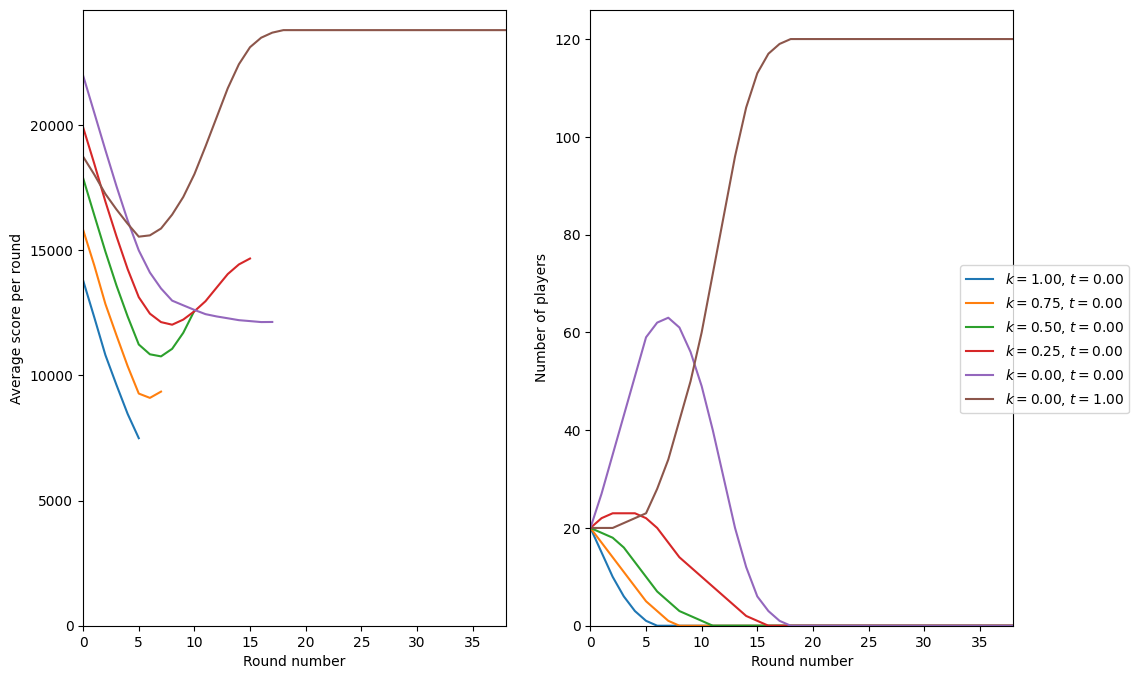

In [18]:
strategies, means, stdevs = stats(hist)

It’s interesting to note that initially, the average score of all strategies decreases. This is because the Evil players have the highest score in the first five rounds, leading to an increase in their population, which decreases the average score of all other strategies. The only strategy that can compete is, indeed,Tit-for-tat, as it earns more points than the constant betrayers thanks to the cooperative behaviour with players of the same species and defecting behaviour towards Evils.

Here’s another important example with only 5 Tit-for-tats grouped with 95 Evil players.

In [19]:
def init_classed(N):
    return np.array([Player(0, 0)] * (N - 5) + [Player(0, 1)] * 5)

N = 100
it = 100
cyc = 100
hist = repeated(N, it, cyc)

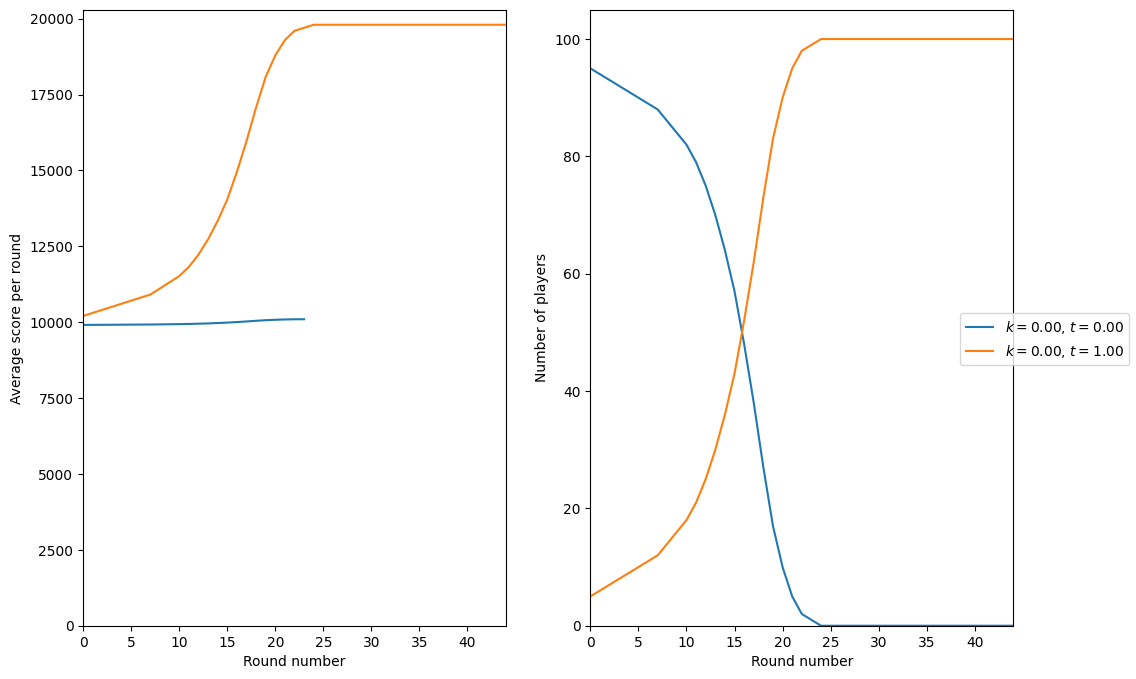

In [20]:
strategies, means, stdevs = stats(hist)

Despite a significant difference in the number of players, the Tit-for-tats eventually dominate over Evil players, thanks to a slightly higher initial average score. Indeed, the Tit-for-tat population is difficult to overcome due to its retaliatory behaviour, resulting in other classes having lower scores against them compared to the scores against themselves.

Now, let’s throw some Spiteful players into the mix, to see if they do as well as Tit-for-tats or better.

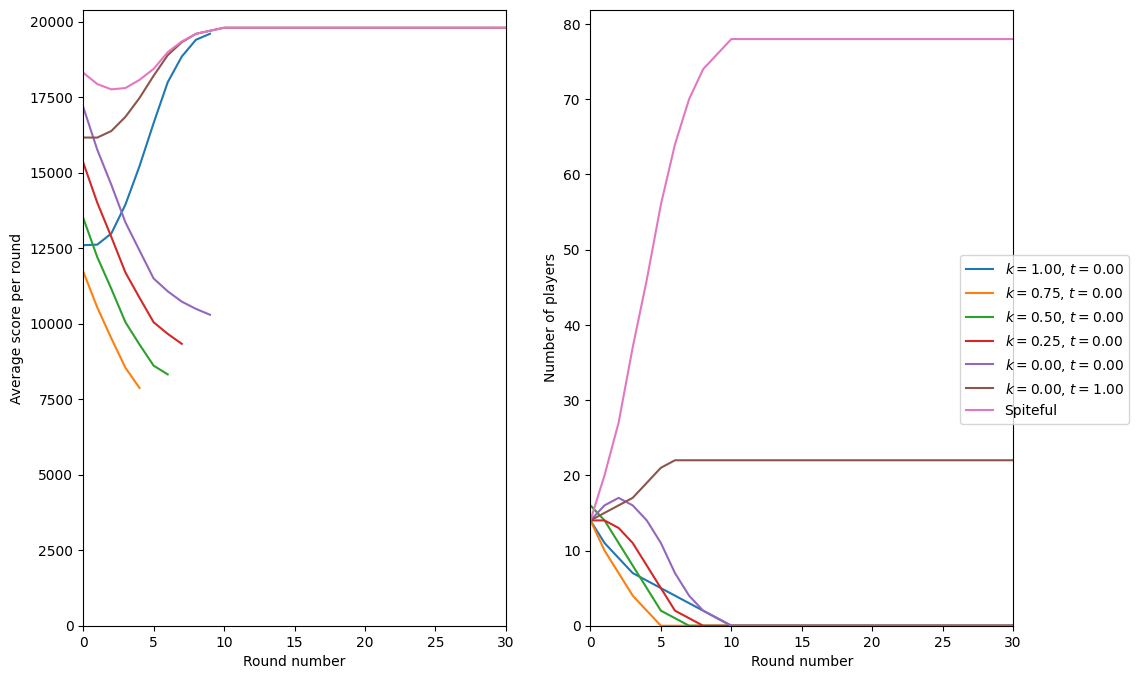

In [22]:
def init_classed(num_players):
    return np.array([Player(1, 0), Player(0.75, 0), Player(0.5, 0), 
                     Player(0.25, 0), Player(0, 0), Player(0, 1),
                     Spiteful()]
                    * (num_players // 7)
                    + [Player(0.5, 0)] * (num_players % 7))

N = 100
it = 100
cyc = 100
hist = repeated(N, it, cyc)
strategies, means, stdevs = stats(hist)

Right from the start, the only strategies that perform reasonably are Evil, Tit-for-tat and Spiteful, as expected. Evil players are the third-longest surviving strategy, but their average score starts to plummet right away. Nice players do not die off as quickly, and their score increases rapidly as well, but they are eventually surpassed by Spiteful and Tit-for-tat players, resulting in an equilibrium population of approximately 20% Tit-for-tats and 80% Spitefuls.

## Mutating strategies

In this section, we’ll follow a new approach to explore strategies that change over time and go over the possibility of random mutations. The basic strategies had a limitation in that a player would always be either reactive (Tit-for-tat) or proactive (Nice, Evil, etc.).

To allow for a player to exhibit both behaviors, we redefined the two parameters $k$ and $t$ to vary continuously in $[-1, 1]$ and $[0, 1]$ respectively, so that the player tit-for-tats with probability $t$ (“anti-tit-for-tats” if $t < 0$, with probability $\vert t\vert$), and cooperates with probability $k$.

In [23]:
def init(N):
    pl = []
    Nsq = int(N**0.5)
    for i in range(Nsq):
        for j in range(Nsq):
            pl.append(Player(i / Nsq, j * 2 / Nsq - 1))
    while len(pl) < N:
        pl.append(Player(0.5, 0))
    return pl

The games are played using the `repeated` function, as in the *battle royale*. Performance is evaluated using the `evolve` function, which operates as follows: players with a score bigger than the average minus one standard deviation advance to the next round, and new players are generated with a random strategy picked from the good-performing population. Then, before proceeding to the next round, all strategies undergo a random mutation.

In [25]:
def evolve(pl, scores, sigma_cutoff=-1):
    N = len(pl)
    tot = sum(scores)
    
    newpl, newscores = [], []
    
    m, s = np.mean(scores), np.std(scores)
    
    for i in range(N):
        if scores[i] > m + sigma_cutoff * s:
            newpl.append(pl[i])
            newscores.append(scores[i])
    
    frac = N // len(newscores)
    for i in range(frac-1):
        for j in range(len(newscores)):
            p = newpl[j]
            newpl.append(Player(p.k, p.t))
    
    while len(newpl) < N:
        p = np.random.choice(newpl)
        newpl.append(Player(p.k, p.t))
    
    for p in newpl:
        p.randomize()
        
    return newpl

Then, we can make an animated plot of the results as follows.

In [28]:
%matplotlib widget

def create_video(N, it, cyc):
    hist = repeated(N, it, cyc, False)
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel(r"Probability of cooperation $k$")
    ax.set_ylabel(r"Probability of tit-for-tatting $t$")

    col = 255 * (np.array(hist[0][1]) - min(hist[0][1])) / (max(hist[0][1]) - min(hist[0][1]))
    rgb = mpl.colormaps["coolwarm"](col)[np.newaxis, :, :3][0]
            
    lines = []
            
    for j in range(len(hist[0][0])):
            k, t = hist[0][0][j].init_values()
            line, = ax.plot(k, t, c=rgb[j], marker=".", linewidth=0)
            lines.append(line)
            
    def animate(i):
        col = 255 * (np.array(hist[i][1]) - min(hist[i][1])) / (max(hist[i][1]) - min(hist[i][1]))
        rgb = mpl.colormaps["coolwarm"](col)[np.newaxis, :, :3][0]
        for j in range(len(lines)):
            lines[j].set_data(hist[i][0][j].init_values())
            lines[j].set_color(rgb[j])
        return lines
    anim = animation.FuncAnimation(fig, animate, interval=500, frames=len(hist))
    plt.show()

    return anim

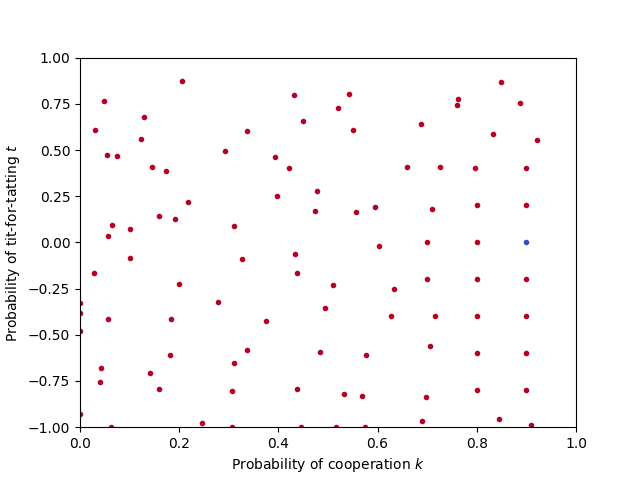

In [29]:
animation = create_video(100, 100, 100)

Here’s a pre-made animation with 400 players and 200 rounds of 100 iterations.

In [30]:
from IPython.display import Video

Video("animation_400_200_100.mov")

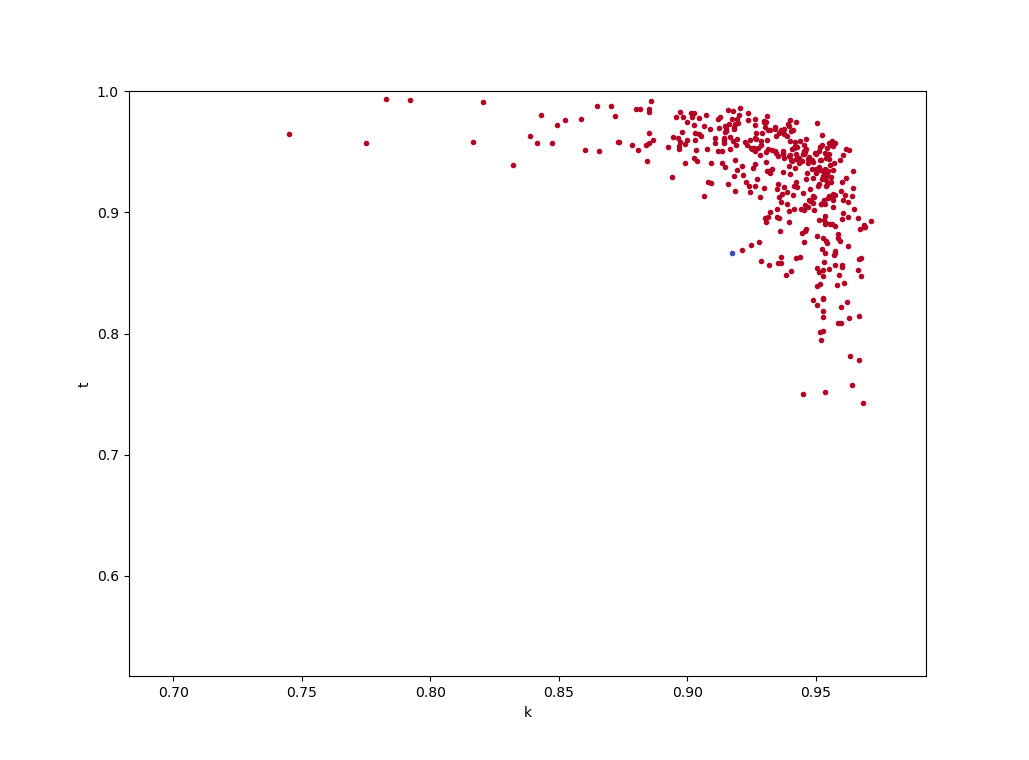

In [31]:
from IPython.display import Image
Image("mutating_closeup.png")

This further emphasizes that in a large population over a sufficient period of time, cooperative behaviors with appropriate safeguards against betrayals tend to outperform both disruptive strategies and foolishly “always-nice” players.

This concept can be seen in real-world examples, such as the success of cooperative business models compared to cut-throat competition, or the stability of a community that rewards cooperation and punishes defection.

It’s also noteworthy that the model shows this trend despite the strong inclination towards defection in one-on-one interactions.